# <center>**When seasonality meets Bayesian: Decomposing seasonalities in Stan**</center>
## <center>Hyunji Moon, Hyeonseop Lee</center>

# Abstract

Multiple seasonalities play a key role in time series forecasting, especially for business time series where seasonal effects are often dramatic. Previous approaches including Fourier decomposition, exponential smoothing, and Seasonal ARIMA do not reflect distinct characteristics of each period in seasonal patterns such as unique behavior of specific day of the week in business data. We propose a multi-dimensional hierarchical model. Intermediate parameters for each seasonal period are first estimated, then mixture of intermediate parameters are then taken, resulting in the model which successfully reflects interactions between multiple seasonalities. Although this process leads to the reduction of data available for each parameter, a robust estimation can be obtained through a hierarchical Bayesian model. Consideration of not only the characteristics of each seasonal periods but also the interactions between characteristics from multiple seasonalities becomes possible through this model. Our new model is implemented in Stan and considerable improvements in prediction accuracy compared to previous models are achieved. Previous models include Fourier decomposition which Prophet uses to model seasonalities. Comparison has been performed on real-world dataset from a nation-scale logistic network.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pystan
import arviz as az
plt.style.use('ggplot')

/usr/local/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


# Introduction

Two problems on modeling seasonalities in time series motivated our proposed model.

1. **Periodic scale jumps.** In business time series, we can easily observe periodic scale jumps, such as trade volume falls in weekend or extreme spikes due to stock adjustment right before the end-of-month evaluation. Previous seasonality models which fit the whole seasonal periods with a single set of parameters hardly capture these extreme patterns. We solve this problem by separating parameters for each seasonal component, such as day of the week or day of the month. Each parameter is fit using hierarchical model to achieve partial pooling.

2. **Effects of multiple seasonalities.** Business time series generally exhibits more than one seasonal patterns. As each seasonal pattern has distinct periods and effects, it is not trivial to design a model that can capture multiple seasonalities at once. We construct a mixture model that estimate the final parameter distributions by taking a mixture of intermediate parameter distributions for each seasonality.

# Models

Our base model assumes time series with linear trend. It models value $y(t)$ at time $t$ as below:

$y(t) = kt + m + \epsilon_t$

where $k$ is the growth rate, $m$ is the offset parameter, and $\epsilon_t$ is the error term.

## Complete Pooling Model

In complete pooling model for baseline, all data points share single set of parameters $k$ and $m$.

$y(t) \sim N(kt + m, \sigma)$

We used Normal(0, 5) for parameters' prior, which Prophet uses.

In [2]:
complete_pooling_model_code = '''
data {
    int<lower=1> T;
    vector[T] t;
    vector[T] y;
}
parameters {
    real k;
    real m;
    real<lower=0> sigma_obs;
}
transformed parameters {
    vector[T] yhat;
    yhat = k * t + m;
}
model {
    k ~ normal(0, 5);
    m ~ normal(0, 5);

    y ~ normal(yhat, sigma_obs);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

## Partial Pooling Model

In partial pooling model, we group data points by periods in seasonality, such as day of the week or day of the month.

Each period $i$ in seasonality has its own set of parameters $k_i$ and $m_i$, and those parameters shares single set of priors $N(\mu_k, \sigma_k)$ and $N(\mu_m, \sigma_m)$. This forms a hierarchical model so parameters can share information through their prior.

$k_i \sim N(\mu_k, \sigma_k)$

$m_i \sim N(\mu_m, \sigma_m)$

$y(t) \sim N(k_it + m_i, \sigma)$

We used proxy variables $p_k$ and $p_m$ to achieve vectorization in likelihood statement.

Priors Normal(0, 5) and Exponential(1) are used for parameters' mean and standard deviation.

In [3]:
partial_pooling_model_code = '''
data {
    int<lower=1> T;
    int<lower=1> P;
    vector[T] t;
    vector[T] y;
    int pool[T];
}
parameters {
    real k_mu;
    real<lower=0> k_sigma;
    real m_mu;
    real<lower=0> m_sigma;
    real k[P];
    real m[P];
    real<lower=0> sigma_obs;
}
transformed parameters {
    vector[T] p_k;
    vector[T] p_m;
    vector[T] yhat;
    for (i in 1:T) {
        p_k[i] = k[pool[i]];
        p_m[i] = m[pool[i]];
    }
    yhat = p_k .* t + p_m;
}
model {
    k_mu ~ normal(0, 5);
    k_sigma ~ exponential(1);
    m_mu ~ normal(0, 5);
    m_sigma ~ exponential(1);

    k ~ normal(k_mu, k_sigma);
    m ~ normal(m_mu, m_sigma);
    sigma_obs ~ normal(0, 0.5);

    y ~ normal(yhat, sigma_obs);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

## Mixture Model

Partial pooling model provides distinct set of parameters for each period in seasonality. However it comes unclear to propose a likelihood on observed value $y$ when we model time series with more than one seasonalites. In mixture model, we take linear mixture of each parameters to obtain single set of parameters. The mixture weight $\theta$ represents contribution of each seasonality to the time series.

$k_{ij} \sim N(\mu_k, \sigma_k)$

$m_{ij} \sim N(\mu_m, \sigma_m)$

$y(t) \sim N((k_i \cdot \theta)t + (m_i \cdot \theta), \sigma)$

In [4]:
mixture_model_code = '''
data {
    int<lower=1> T;
    int<lower=1> D;
    int<lower=1> P;
    vector[T] t;
    vector[T] y;
    int pool[T, D];
    vector[D] season_w;
}
parameters {
    real k_mu;
    real<lower=0> k_sigma;
    real m_mu;
    real<lower=0> m_sigma;
    real k[D, P];
    real m[D, P];
    simplex[D] theta;
    real<lower=0> sigma_obs;
}
transformed parameters {
    matrix[T, D] p_k;
    matrix[T, D] p_m;
    vector[T] yhat;
    for (i in 1:T) {
        for (d in 1:D) {
            p_k[i, d] = k[d, pool[i, d]];
            p_m[i, d] = m[d, pool[i, d]];
        }
    }
    yhat = (p_k * theta) .* t + (p_m * theta);
}
model {
    k_mu ~ normal(0, 5);
    k_sigma ~ exponential(1);
    m_mu ~ normal(0, 5);
    m_sigma ~ exponential(1);

    for (d in 1:D) {
        k[d] ~ normal(k_mu, k_sigma);
        m[d] ~ normal(m_mu, m_sigma);
    }
    sigma_obs ~ normal(0, 0.5);

    y ~ normal(yhat, sigma_obs);
    target += dirichlet_lpdf(theta | season_w);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

## Fourier Decomposition Model

We also implemented Fourier decomposition model which relies on Fourier series to reflect periodic effects, which is one of the popular method for modeling single or multiple seasonalities and what Prophet uses, for comparison. We perform regression to time series with Fourier terms $X_t$ and regression parameter $\beta$ as below:

$y(t) \sim N(k_it + X_t \cdot \beta + m_i, \sigma)$

where Fourier term $X_t$ can be constructed as below:

$X_t = [\frac{\cos(2 \pi t)}{P}, \frac{\sin(2 \pi t)}{P}, \dots, \frac{\cos(2 \pi n t)}{P}, \frac{\sin(2 \pi n t)}{P}]$

where $P$ is the regular period of the seasonality and $n$ is the order of the Fourier series.

Normal(0, 10) is used for $\beta$'s prior.

In [5]:
def generate_fourier_terms(ds, period, order):
    t = np.array((ds - pd.datetime(1970, 1, 1)).dt.total_seconds().astype(np.float)) / (3600. * 24.)
    terms = np.column_stack([
        fun((2. * (i + 1) * np.pi * t / period))
        for i in range(order)
        for fun in (np.sin, np.cos)
    ])
    return terms

fourier_deomposition_model_code = '''
data {
    int<lower=1> T;
    int<lower=1> K;
    vector[T] t;
    vector[T] y;
    matrix[T,K] X;
}
parameters {
    real k;
    real m;
    vector[K] beta;
    real<lower=0> sigma_obs;
}
transformed parameters {
    vector[T] yhat;

    yhat = k * t + X * beta + m;
}
model {
    k ~ normal(0, 5);
    m ~ normal(0, 5);
    beta ~ normal(0, 10);
    sigma_obs ~ normal(0, 0.5);

    y ~ normal(yhat, sigma_obs);
}
generated quantities{
    vector[T] log_lik;
    for (i in 1:T) {
        log_lik[i] = normal_lpdf(y[i]|yhat[i], sigma_obs);
    }
}
'''

In [6]:
cpm = pystan.StanModel(model_code=complete_pooling_model_code)
ppm = pystan.StanModel(model_code=partial_pooling_model_code)
mm = pystan.StanModel(model_code=mixture_model_code)
fdm = pystan.StanModel(model_code=fourier_deomposition_model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a49272fb557be9008e01eafb7c937b41 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_503a294de0d59e15bb48a0573af56c67 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b23f55bb6707e56680a929e21222f683 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bab9eae5021c8c4efc7591e854a23b4e NOW.


In [7]:
def generate_cpm_data(df):
    return {
        'T': df.shape[0],
        't': df['t'],
        'y': df['y'],
    }

def predict_cpm(params, df):
    df = df.copy()
    df['yhat'] = params['k'] * df['t'] + params['m']
    return df

def generate_ppm_data(df, pool):
    return {
        'T': df.shape[0],
        'P': df[pool].unique().shape[0],
        't': df['t'],
        'y': df['y'],
        'pool': df[pool],
    }

def predict_ppm(params, df, pool):
    df = df.copy()
    k = np.array([params['k'][i - 1] for i in df[pool]])
    m = np.array([params['m'][i - 1] for i in df[pool]])
    df['yhat'] = k * df['t'] + m
    return df

def generate_mm_data(df, season_w, *pools):
    return {
        'T': df.shape[0],
        'D': len(pools),
        'P': max([df[pool].unique().shape[0] for pool in pools]),
        't': df['t'],
        'y': df['y'],
        'pool': np.transpose([df[pool] for pool in pools]),
        'season_w' : season_w
    }

def predict_mm(params, df, *pools):
    df = df.copy()
    k = np.array([[params['k'][p][i - 1] for i in df[pool]] for p, pool in enumerate(pools)])
    m = np.array([[params['m'][p][i - 1] for i in df[pool]] for p, pool in enumerate(pools)])
    df['yhat'] = np.dot(k.transpose(), params['theta']) * df['t'] + np.dot(m.transpose(), params['theta'])
    return df

def generate_fdm_data(df, *terms):
    X = np.concatenate([generate_fourier_terms(df['ds'], period, order) for period, order in terms], axis=1)
    return {
        'T': df.shape[0],
        'K': sum(order * 2 for _, order in terms),
        't': df['t'],
        'y': df['y'],
        'X': X,
    }

def predict_fdm(params, df, *terms):
    df = df.copy()
    X = np.concatenate([generate_fourier_terms(df['ds'], period, order) for period, order in terms], axis=1)
    df['yhat'] = params['k'] * df['t'] + np.dot(X, params['beta']) + params['m']
    return df

# Evaluation

For evaluation, we use real world dataset from a nation-scale logistic network. Each time series represents logistic units transported for recent two years according to certain kind of logistics.

We normalize $t$ and $y$ which represent timestamp and time series value of each data point respectively. Also we add period columns, day of the week and day of the month, for the convenience of populating model inputs.

In [8]:
def preprocess(df):
    df['ds'] = pd.to_datetime(df['ds'])
    df['weekday'] = df['ds'].dt.weekday + 1
    df['monthday'] = df['ds'].dt.day
    t_start = df['ds'].min()
    t_scale = df['ds'].max() - t_start
    df['t'] = (df['ds'] - t_start) / t_scale
    df['y_scale'] = df['y'].abs().max()
    df['y'] = df['y'] / df['y_scale']
    return df

We are performing an expanding window cross validation with given size of initial data points and horizon.

In [9]:
def generate_cv_data(df, initial, horizon):
    n = df.shape[0]
    cutoff = initial
    while cutoff + horizon <= n:
        train_df = df.iloc[:cutoff].reset_index(drop=True)
        test_df = df.iloc[cutoff:cutoff + horizon].reset_index(drop=True)
        yield train_df, test_df
        cutoff += horizon

Since our dataset contains values of various scale, relative errors would be overly sensitive to data point of tiny scale. We are using mean absolute error, divided by mean true value for comparison, for each fold in cross validation dataset.

In [10]:
def calculate_mae(df):
    y, yhat = df['y'] * df['y_scale'], df['yhat'] * df['y_scale']
    return np.mean(np.abs(y - yhat))

def calculate_mape(df):
    y, yhat = df['y'] * df['y_scale'], df['yhat'] * df['y_scale']
    return np.mean(np.abs(y - yhat)) / np.mean(y)

In [11]:
def calculate_loo(stan_fit):
    data_ar = az.from_pystan(
        posterior = stan_fit,
        posterior_predictive = ['yhat'],
        observed_data = ['y'],
        log_likelihood='log_lik',
        )
    return az.loo(data_ar).loo

In [12]:
def plot_data(df):
    df = df.iloc[-90:].reset_index(drop=True)
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    df['y'].plot(ax=axes[0])
    axes[0].set_ylabel('y')
    pd.plotting.autocorrelation_plot(df['y'], ax=axes[1])
    fig.tight_layout()

def plot_predict(df):
    df = df.iloc[-90:].reset_index(drop=True)
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    df.plot(ax=ax)
    ax.set_ylabel('y')
    plt.savefig(f'{len(df)}.eps', format='eps')

## Data I: Delivery

Our first dataset delivery shows strong weekly periodicity. We can observe sharp fall in time series every Sunday.

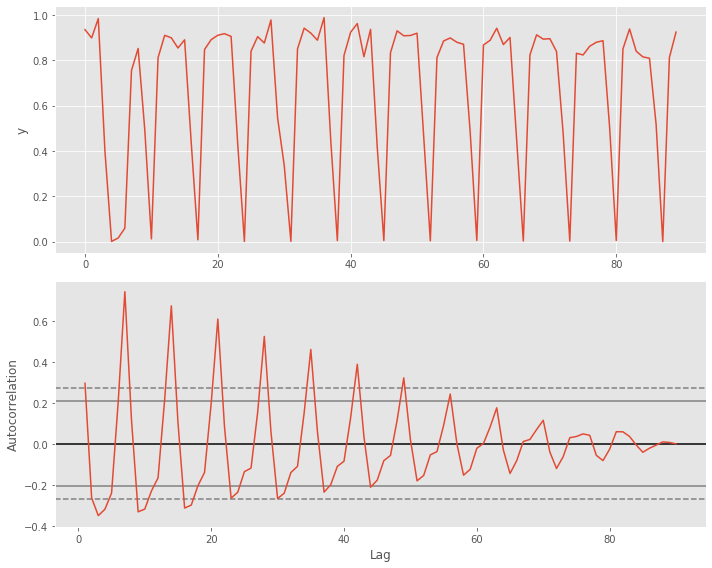

In [57]:
df = preprocess(pd.read_csv('delivery.csv'))
plot_data(df)

For Fourier decomposition model we configure a weekly seasonality by setting 7 days as period $P$ and 3 as Fourier order $n$.

In [ ]:
data = generate_fdm_data(df, (7, 3))
params = fdm.optimizing(data=data)
predict_df = predict_fdm(params, df, (7, 3))
fdm_yhat_w = predict_df['yhat']

fdm_mae_w = np.asarray([
    calculate_mae(predict_fdm(fdm.optimizing(data=generate_fdm_data(train_df, (7, 3))), test_df, (7, 3)))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [ ]:
data = generate_cpm_data(df)
params = cpm.optimizing(data=data)
predict_df = predict_cpm(params, df)
cpm_yhat_w = predict_df['yhat']

cpm_mae_w = np.asarray([
    calculate_mae(predict_cpm(cpm.optimizing(data=generate_cpm_data(train_df)), test_df))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

Since the dataset shows weekly seasonality, we are pooling data points by day of the week. In the case of pooling models, we used the Newton algorithm for robust convergence of optimization.

In [60]:
data = generate_ppm_data(df, 'weekday')
params = ppm.optimizing(data=data)
predict_df = predict_ppm(params, df, 'weekday')
ppm_yhat_w = predict_df['yhat']

ppm_mae_w = np.asarray([
    calculate_mae(predict_ppm(ppm.optimizing(data=generate_ppm_data(train_df, 'weekday'), algorithm='Newton'), test_df, 'weekday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [ ]:
season_w = np.array([5,1])
data = generate_mm_data(df,season_w, 'weekday', 'monthday')

params = mm.optimizing(data=data)
predict_df = predict_mm(params, df, 'weekday', 'monthday')
mm_yhat_w = predict_df['yhat']

mm_mae_w = np.asarray([
    calculate_mae(predict_mm(mm.optimizing(data=generate_mm_data(train_df, season_w,'weekday', 'monthday'), algorithm='Newton'), test_df, 'weekday', 'monthday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
# mm_loo = np.asarray([
#     calculate_loo(mm.sampling(data = generate_mm_data(train_df, 'weekday', 'monthday')))
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])

Below is evaluation result in mean absolute error and fitted models.

Complete pooling model does not consider weekly seasonality at all because every data points share single set of parameters.

Fourier decomposition model and partial pooling model behaves almost identically and negligible difference in performance is observed.

In [ ]:
total_df = pd.DataFrame({
    'y': df['y'],
    'Fourier Decomposition': fdm_yhat,
    'Complete Pooling': cpm_yhat,
    'Partial Pooling': ppm_yhat,
    'Mixed Pooling' : mm_yhat
})
plot_predict(total_df)

mae_df = pd.DataFrame({
    'fdm_mae': fdm_mae_w,
    'cpm_mae': cpm_mae_w,
    'ppm_mae': ppm_mae_w,
    'mm_mae' : mm_mae_w
})
mae_df.mean()

In [ ]:
cpm_loo_w = np.asarray([
    calculate_loo(cpm.sampling(data = generate_cpm_data(train_df)))
    for train_df, _ in generate_cv_data(df, 365, 30)
])
ppm_loo_w = np.asarray([
    calculate_loo(ppm.sampling(data = generate_ppm_data(train_df,'weekday')))
    for train_df, _ in generate_cv_data(df, 365, 30)
])
mm_loo_w = np.asarray([
    calculate_loo(mm.sampling(data = generate_mm_data(train_df, season_w, 'weekday', 'monthday')))
    for train_df, _ in generate_cv_data(df, 365, 30)
])

fdm_loo_w = np.asarray([
    calculate_loo(fdm.sampling(data = generate_fdm_data(train_df,(7, 3)))) 
    for train_df, _ in generate_cv_data(df, 365, 30)
])
loo_df_w = pd.DataFrame({
    'fdm_loo': fdm_loo_w,
    'cpm_loo': cpm_loo_w,
    'ppm_loo': ppm_loo_w,
    'mm_loo': mm_loo_w,
})
print(loo_df_w.mean())
# fdm_loo   -727.884554
# cpm_loo    268.452426
# ppm_loo   -729.467722
# mm_loo    -730.886467
# dtype: float64

## Data II: Restock

Our second dataset restock shows clear monthly periodicity: it spikes at every beginning and end of the month. In autocorrelation, however, a relatively obscure periodicity is observed because the length of each month differs.

In [ ]:
df = preprocess(pd.read_csv('restock.csv'))
plot_data(df)

For Fourier decomposition model we configure a monthly seasonality by setting 30.4375 days as period $P$ and 5 as Fourier order $n$.

In [ ]:
data = generate_fdm_data(df, (30.4375, 5))
params = fdm.optimizing(data=data)
predict_df = predict_fdm(params, df, (30.4375, 5))
fdm_yhat_m = predict_df['yhat']

fdm_mae_m = np.asarray([
    calculate_mae(predict_fdm(fdm.optimizing(data=generate_fdm_data(train_df, (30.4375, 5))), test_df, (30.4375, 5)))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [ ]:
data = generate_cpm_data(df)
params = cpm.optimizing(data=data)
predict_df = predict_cpm(params, df)
cpm_yhat_m = predict_df['yhat']

cpm_mae_m = np.asarray([
    calculate_mae(predict_cpm(cpm.optimizing(data=generate_cpm_data(train_df)), test_df))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

Since the dataset shows monthly seasonality, we are pooling data points by day of the month.

In [ ]:
data = generate_ppm_data(df, 'monthday')
params = ppm.optimizing(data=data)
predict_df = predict_ppm(params, df, 'monthday')
ppm_yhat_m = predict_df['yhat']

ppm_mae_m = np.asarray([
    calculate_mae(predict_ppm(ppm.optimizing(data=generate_ppm_data(train_df, 'monthday'), algorithm='Newton'), test_df, 'monthday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [ ]:
season_w = np.array([1,5])
data = generate_mm_data(df,season_w, 'weekday', 'monthday')

params = mm.optimizing(data=data)
predict_df = predict_mm(params, df, 'weekday', 'monthday')
mm_yhat = predict_df['yhat']

mm_mae_m = np.asarray([
    calculate_mae(predict_mm(mm.optimizing(data=generate_mm_data(train_df, season_w,'weekday', 'monthday'), algorithm='Newton'), test_df, 'weekday', 'monthday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

In [ ]:
cpm_loo = np.asarray([
    calculate_loo(cpm.sampling(data = generate_cpm_data(train_df)))
    for train_df, _ in generate_cv_data(df, 365, 30)
])
# ppm_loo_m = np.asarray([
#     calculate_loo(ppm.sampling(data = generate_ppm_data(train_df,'monthday')))
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])
mm_loo_m = np.asarray([
    calculate_loo(mm.sampling(data = generate_mm_data(train_df, season_w, 'weekday', 'monthday')))
    for train_df, _ in generate_cv_data(df, 365, 30)
])

# fdm_loo_m = np.asarray([
#     calculate_loo(fdm.sampling(data = generate_fdm_data(train_df,(30.4375, 5)))) 
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])
loo_df = pd.DataFrame({
    'fdm_loo': fdm_loo_m,
    'cpm_loo': cpm_loo,
    'ppm_loo': ppm_loo_m,
    'mm_loo': mm_loo_m,
})
print(loo_df.mean())
# fdm_loo   -727.795458
# cpm_loo    268.477949
# ppm_loo   -729.693335
# mm_loo    -728.662423
# dtype: float64

Partial polling model is showing a significantly higher performance compared to other models.

The plot shows that Fourier decomposition model with given Fourier order does not fit the extreme spikes correctly.

In [ ]:
total_df_m = pd.DataFrame({
    'y': df['y'],
    'Fourier Decomposition': fdm_yhat_m,
    'Complete Pooling': cpm_yhat_m,
    'Partial Pooling': ppm_yhat_m,
    'Mixed Pooling' : mm_yhat_m
})
plot_predict(total_df_m)

mae_df_m = pd.DataFrame({
    'fdm_mae': fdm_mae_m,
    'cpm_mae': cpm_mae_m,
    'ppm_mae': ppm_mae_m,
    'mm_mae' : mm_mae_m
})
mae_df_m.mean()

## Data III: Shipment

Our third dataset shipment shows strong monthly periodicity as well as subtle monthly periodicity.

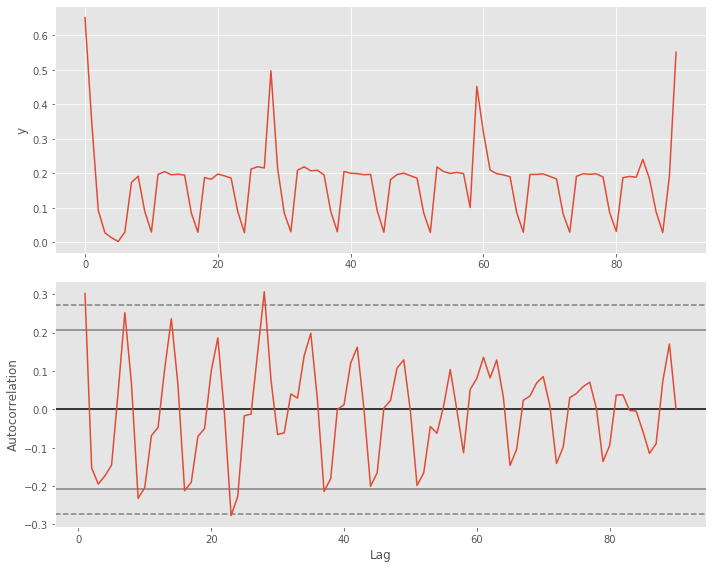

In [13]:
df = preprocess(pd.read_csv('shipment.csv'))
plot_data(df)

For Fourier decomposition model we configure both weekly and monthly seasonality.

In [33]:
data = generate_fdm_data(df, (7, 3), (30.4375, 5))
params = fdm.optimizing(data=data)
predict_df = predict_fdm(params, df, (7, 3), (30.4375, 5))
fdm_yhat_wm = predict_df['yhat']

fdm_mae_wm = np.asarray([
    calculate_mae(predict_fdm(fdm.optimizing(data=generate_fdm_data(train_df, (7, 3), (30.4375, 5))), test_df, (7, 3), (30.4375, 5)))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])  
fdm_mape_wm = np.asarray([
    calculate_mape(predict_fdm(fdm.optimizing(data=generate_fdm_data(train_df, (7, 3), (30.4375, 5))), test_df, (7, 3), (30.4375, 5)))
    for train_df, test_df in generate_cv_data(df, 365, 30)
]) 
# fdm_loo_wm = np.asarray([
#     calculate_loo(fdm.sampling(data = generate_fdm_data(train_df,(7, 3), (30.4375, 5)))) 
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [31]:
data = generate_cpm_data(df)
params = cpm.optimizing(data=data)
predict_df = predict_cpm(params, df)
cpm_yhat_wm = predict_df['yhat']

cpm_mae_wm = np.asarray([
    calculate_mae(predict_cpm(cpm.optimizing(data=generate_cpm_data(train_df)), test_df))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
cpm_mape_wm = np.asarray([
    calculate_mape(predict_cpm(cpm.optimizing(data=generate_cpm_data(train_df)), test_df))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
# cpm_loo_wm = np.asarray([
#     calculate_loo(cpm.sampling(data = generate_cpm_data(train_df)))
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])

In [32]:
data = generate_ppm_data(df, 'weekday')
params = ppm.optimizing(data=data)
predict_df = predict_ppm(params, df, 'weekday')
ppm_yhat_wm = predict_df['yhat']

ppm_mae_wm = np.asarray([
    calculate_mae(predict_ppm(ppm.optimizing(data=generate_ppm_data(train_df, 'weekday'), algorithm='Newton'), test_df, 'weekday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
ppm_mape_wm = np.asarray([
    calculate_mape(predict_ppm(ppm.optimizing(data=generate_ppm_data(train_df, 'weekday'), algorithm='Newton'), test_df, 'weekday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
# ppm_loo_wm = np.asarray([
#     calculate_loo(ppm.sampling(data = generate_ppm_data(train_df,'weekday')))
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])

To consider both weekly and monthly seasonality in pooling model, we use our mixture model and provide pooling dimensions corresponding to each seasonality.

In [26]:
season_w = np.array([5,1])
data = generate_mm_data(df, season_w, 'weekday', 'monthday')
params = mm.optimizing(data=data)
predict_df = predict_mm(params, df, 'weekday', 'monthday')
mm_yhat_wm = predict_df['yhat']

mm_mae_wm = np.asarray([
    calculate_mae(predict_mm(mm.optimizing(data=generate_mm_data(train_df, season_w, 'weekday', 'monthday'), algorithm='Newton'), test_df, 'weekday', 'monthday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])
# mm_loo_wm = np.asarray([
#     calculate_loo(mm.sampling(data = generate_mm_data(train_df,season_w, 'weekday', 'monthday')))
#     for train_df, _ in generate_cv_data(df, 365, 30)
# ])

In [36]:
mm_mape_wm = np.asarray([
    calculate_mape(predict_mm(mm.optimizing(data=generate_mm_data(train_df, season_w, 'weekday', 'monthday'), algorithm='Newton'), test_df, 'weekday', 'monthday'))
    for train_df, test_df in generate_cv_data(df, 365, 30)
])

Overall, mixture models performs the best for both measures.

Partial pooling model with weekly seasonality seems to be largely influenced by monthly spikes and appears to fit on a larger value.

Fourier decomposition models performs better than partial polling model but like with the restock dataset it does not fit the monthly seasonality well.

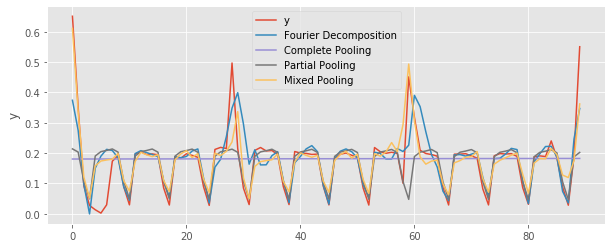

In [22]:
total_df_wm = pd.DataFrame({
    'y': df['y'],
    'Fourier Decomposition': fdm_yhat_wm,
    'Complete Pooling': cpm_yhat_wm,
    #'Partial Pooling': ppm_yhat_wm,
    'Mixed Pooling' : mm_yhat_wm
})
plot_predict(total_df_wm)


In [27]:
mae_df_wm = pd.DataFrame({
    'fdm_mae': fdm_mae_wm,
    'cpm_mae': cpm_mae_wm,
    #'ppm_mae': ppm_mae_w,
    'mm_mae' : mm_mae_wm
})
mae_df_wm.mean() #54220.316478

fdm_mae    5.395943e+04
cpm_mae    7.733300e+04
mm_mae     1.209045e+07
dtype: float64

In [29]:
mape_df_wm = pd.DataFrame({
    'fdm_mae': fdm_mape_wm,
    'cpm_mae': cpm_mape_wm,
    'ppm_mae': ppm_mape_wm,
    'mm_mae': mm_mape_wm,
})
print(mape_df_wm.mean())

NameError: name 'fdm_mape_wm' is not defined

In [23]:
mae_df_wm = pd.DataFrame({
    'fdm_mae': fdm_mae_wm,
    'cpm_mae': cpm_mae_wm,
    'ppm_mae': ppm_mae_wm,
    'mm_mae': mm_mae_wm,
})
print(mae_df_wm.mean())
loo_df_wm = pd.DataFrame({
    'fdm_loo': fdm_loo_wm,
    'cpm_loo': cpm_loo_wm,
    'ppm_loo': ppm_loo_wm,
    'mm_loo': mm_loo_wm,
})
print(loo_df_wm.mean())

fdm_mae    53959.431073
cpm_mae    77333.002815
ppm_mae    57838.610413
mm_mae     54220.316478
dtype: float64
fdm_loo   -1053.859531
cpm_loo    -731.105606
ppm_loo    -855.489441
mm_loo    -1279.167838
dtype: float64


# Analysis

In [ ]:
def plot_fit(fit, legend=None):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    samples = fit.extract()
    for i, var in enumerate(['m', 'k']):
        plot = pd.DataFrame(samples[var]).plot.kde(ax=axes[i][0])
        axes[i][0].set_xlabel(var)
        if legend is not None:
            plot.legend([plot.lines[j] for j in legend], legend)
        plot = pd.DataFrame(samples[var]).sample(500, axis=0).sort_index().plot.line(ax=axes[i][1])
        axes[i][1].set_xlabel(var)
        if legend is not None:
            plot.legend([plot.lines[j] for j in legend], legend)
    fig.tight_layout()

def plot_mixture_fit(fit, pools, legends=[None, None]):
    fig, axes = plt.subplots(len(pools) * 2 + 1, 2, figsize=(10, 8 * len(pools) + 4))
    samples = fit.extract()
    for i, pool in enumerate(pools):
        for j, var in enumerate(['m', 'k']):
            a = i * 2 + j
            plot = pd.DataFrame(samples[var][:,i,:pool]).plot.kde(ax=axes[a][0])
            axes[a][0].set_xlabel(f'{var}_{i}')
            if legends[i] is not None:
                plot.legend([plot.lines[k] for k in legends[i]], legends[i])
            plot = pd.DataFrame(samples[var][:,i,:pool]).sample(500, axis=0).sort_index().plot.line(ax=axes[a][1])
            axes[a][1].set_xlabel(f'{var}_{i}')
            if legends[i] is not None:
                plot.legend([plot.lines[k] for k in legends[i]], legends[i])
    pd.DataFrame(samples['theta']).plot.kde(ax=axes[-1][0])
    axes[-1][0].set_xlabel('theta')
    pd.DataFrame(samples['theta']).sample(500, axis=0).sort_index().plot.line(ax=axes[-1][1])
    axes[-1][1].set_xlabel('theta')
    fig.tight_layout()

## Parameter divergence in partial polling

In delivery dataset, there is a sharp fall in time series every Sunday. Parameter plots from partial polling model below shows that the probability distribution of the parameters $m$ and $k$ of the 6th day of the week is differentiated from the other parameters.

In [ ]:
df = preprocess(pd.read_csv('delivery.csv'))
data = generate_ppm_data(df, 'weekday')
stan_fit = ppm.sampling(data=data)
plot_fit(stan_fit)
pystan.check_hmc_diagnostics(stan_fit)

Similarly, in restock data set, we can see that the probability distributions of the parameters $m$ and $k$ at the beginning and end of the month are differentiated.

In [ ]:
df = preprocess(pd.read_csv('restock.csv'))
data = generate_ppm_data(df, 'monthday')
stan_fit = ppm.sampling(data=data)
plot_fit(stan_fit, legend=[0, 30])
pystan.check_hmc_diagnostics(stan_fit)

## Seasonality contribution factor $\theta$

We can use theta with extreme care to account for the interaction of seasonalities. Seasonality with higher mixture weight might be said to have a greater effect on time series.

In the bottom plot, you can see the probability distribution of the mixture weight $\theta$ of weekly seasonality parameters and monthly seasonality parameters in the shipment dataset. The maximum a posteriori estimates of each weight are about 0.6 and 0.4, so it can be said that the weekly seasonality affects about twice the monthly seasonality, linearly.

In [ ]:
df = preprocess(pd.read_csv('shipment.csv'))
data = generate_mm_data(df, 'weekday', 'monthday')
stan_fit = mm.sampling(data=data)
plot_mixture_fit(stan_fit, [7, 31], legends=[None, [0, 29, 30]])
pystan.check_hmc_diagnostics(stan_fit)

On the other hand, in the delivery dataset, where the monthly seasonality is hardly observed, weight for monthly seasonality is distributed near zero.

In [ ]:
df = preprocess(pd.read_csv('delivery.csv'))
data = generate_mm_data(df, 'weekday', 'monthday')
stan_fit = mm.sampling(data=data)
plot_mixture_fit(stan_fit, [7, 31], legends=[None, []])
pystan.check_hmc_diagnostics(stan_fit)

# Conclusion

We have proposed a hierarchical model for time series data with multiple seasonalities. We have demonstrated the model with real-world dataset from a logistic network and evaluated among simpler models or models with previous methods. We have compared the new model with the previous methods through validation and confirmed that the prediction performance in the given dataset was greatly improved. Moreover, we have shown that the fitted parameters can reasonably explain the contribution of each seasonality to time series.

The new model utilized the strengths of the hierarchical Bayesian model and was able to achieve both robust estimation and model interpretability. Stan has made the overall process of developing and utilizing Bayesian models effective and concise. We plan to use the model and the Stan-based implementation for the prediction in real-world logistics industry.

# References

1. Bertsimas, D., Bjarnadóttir, M. V., Kane, M. A., Kryder, J. C., Pandey, R., Vempala, S., & Wang, G. (2008). Algorithmic prediction of health-care costs. Operations Research, 56(6), 1382-1392.

1. Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). Bayesian data analysis. Chapman and Hall/CRC.

1. Gelman, A., & Hill, J. (2006). Data analysis using regression and multilevel/hierarchical models. Cambridge university press.

1.	Hyndman, R. J., & Athanasopoulos, G. (2018). Forecasting: principles and practice. OTexts.

1. Hyndman, R. J., Koehler, A. B., Snyder, R. D., & Grose, S. (2002). A state space framework for automatic forecasting using exponential smoothing methods. International Journal of forecasting, 18(3), 439-454.

1. Shumway, R. H., & Stoffer, D. S. (2017). Time series analysis and its applications: with R examples. Springer.
 
1. Taylor, S. J., & Letham, B. (2018). Forecasting at scale. The American Statistician, 72(1), 37-45.